In [31]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from keras.layers import Reshape
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

In [32]:
x = np.load('total_images.npy')

In [33]:
y = np.load('ground_truth_resized.npy')

In [34]:
x.shape

(2000, 256, 256, 3)

In [35]:
train_indices = np.random.choice(2000,1500,replace = False)
x_train_images = []
y_train_labels = [] 
for i in train_indices:
    x_train_images.append(x[i])
    y_train_labels.append(y[i])

test_indices = [xy for xy in range(2000) if xy not in train_indices]
x_test_images = []
y_test_labels = []

for i in test_indices:
    x_test_images.append(x[i])
    y_test_labels.append(y[i])


In [36]:
x_train = np.array(x_train_images)
x_test = np.array(x_test_images)
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)

In [19]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [37]:
rows = 256
cols = 256

In [38]:
data_shape = 216*64
weight_decay = 0.00011

In [39]:
# Defines the input tensor
inputs = Input(shape=(None,None,3))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L9 = Activation('relu')(L8)
L10 = Conv2D(128,(3,3),dilation_rate= (2,2), padding = "same", activation='relu', name = "conv_dil_1")(L9)
L11 = BatchNormalization()(L10)
L12 = Activation('relu')(L11)
L13 = Conv2D(128,(3,3),dilation_rate= (8,8), padding = "same", activation='relu', name = "conv_dil_3")(L12)
L14 = BatchNormalization()(L13)
L15 = Activation('relu')(L14)
L16 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_1")(L6)
L17 = Add()([L15,L16])
L18 = UpSampling2D( size = (2,2)) (L17)

L18 = Conv2D(128,(3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L20 = Activation('relu')(L19)
L21 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_2")(L3)
L21 = Add()([L20,L21])
L22 = UpSampling2D(size = (2,2))(L21)
L22 = Conv2D(64, (3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L22)
L23 = BatchNormalization()(L22)
L24 = Activation('relu')(L23)
L25 = Conv2D(1,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L24)

L26 = Activation('sigmoid')(L25)
model = Model(inputs = inputs, outputs = L26)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, None, None, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, None, None, 6 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, None, None, 6 0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
max_poolin

In [15]:
y_train = y_train.reshape(y_train.shape[0],256,256,1)

In [16]:
y_test = y_test.reshape(y_test.shape[0],256,256,1)

In [40]:
smooth = 1

In [41]:
def dice_cf(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [42]:
def dice_cf_loss(y_true, y_pred):
    return -dice_cf(y_true, y_pred)

In [43]:
def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_cf_loss(y_true, y_pred))

In [44]:
optimiser = optimizers.Adam(lr = 0.01)

In [45]:
model.compile(optimizer=optimiser,loss=dice_cf_loss,metrics=['accuracy',dice_cf])

In [46]:
#Defining Callback functions which will be called by model during runtime when specified condition satisfies
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('segmentation_lr_e2_bs4.csv')
model_chekpoint = ModelCheckpoint("segmentation_lr_e2_bs4.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [24]:
model.fit(x_train,y_train,batch_size=4,epochs=200,validation_data=(x_test, y_test),callbacks=[lr_reducer, csv_logger,model_chekpoint])

Train on 1500 samples, validate on 500 samples
Epoch 1/200
1500/1500 [==============================] - 496s - loss: -0.5415 - acc: 0.8524 - dice_coef: 0.6148 - val_loss: -0.5443 - val_acc: 0.8490 - val_dice_coef: 0.6322
Epoch 2/200
1500/1500 [==============================] - 488s - loss: -0.6840 - acc: 0.9031 - dice_coef: 0.7295 - val_loss: -0.6818 - val_acc: 0.9088 - val_dice_coef: 0.7294
Epoch 3/200
1500/1500 [==============================] - 488s - loss: -0.7350 - acc: 0.9197 - dice_coef: 0.7747 - val_loss: -0.5421 - val_acc: 0.8939 - val_dice_coef: 0.5737
Epoch 4/200
1500/1500 [==============================] - 488s - loss: -0.7573 - acc: 0.9262 - dice_coef: 0.7916 - val_loss: -0.7366 - val_acc: 0.9236 - val_dice_coef: 0.7709
Epoch 5/200
1500/1500 [==============================] - 488s - loss: -0.7752 - acc: 0.9301 - dice_coef: 0.8029 - val_loss: -0.5978 - val_acc: 0.8961 - val_dice_coef: 0.6275
Epoch 6/200
1500/1500 [==============================] - 488s - loss: -0.7816 - acc

KeyboardInterrupt: 

In [25]:
model.load_weights('segmentation_lr_e2_bs4.hdf5')

In [39]:
testing_image = x_test[1].reshape((1,256,256,3))

In [40]:
prediction = model.predict(testing_image)

In [43]:
prediction = prediction.reshape((256,256))

In [49]:
sample = prediction > 0.5

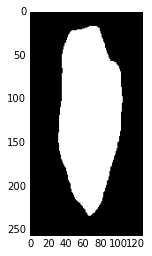

In [51]:
plt.imshow(sample, cmap = "gray")

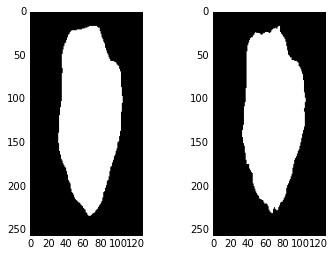

In [53]:
plt.subplot(1,2,1)
plt.imshow(sample, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(gt, cmap = "gray")

In [12]:
Accuracy=getTestSetAccuracy()


In [13]:
print("Test set accuracy-",Accuracy)

Test set accuracy- 0.8602
